# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley, 2016

# 1) Monty: The Python Siri

Let's make a Siri-like program with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

In [56]:
import wave
import pyaudio
import houndify
from keys import client_id, client_key, user, pwd # contains Houndify API info and gmail username/password
import json
import smtplib
from email.mime.text import MIMEText
import urllib.request

In [2]:
def record_audio(fname, rec_sec=5):
    """Record 5 seconds of audio data and writes it to file"""
    chunk = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 16000
    RECORD_SECONDS = rec_sec
    WAVE_OUTPUT_FILENAME = fname
    p = pyaudio.PyAudio()
    stream = p.open(format = FORMAT,
        channels = CHANNELS,
        rate = RATE,
        input = True,
        frames_per_buffer = chunk)
    all = []
    for i in range(0, int(RATE / chunk * RECORD_SECONDS)):
        data = stream.read(chunk)
        all.append(data)
    print("* done recording")
    stream.close()
    p.terminate()
    data = b"".join(all)
    wf = wave.open(WAVE_OUTPUT_FILENAME, "wb")
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()

In [45]:
def do_math(response):
    """
    Returns the formula and result that Houndify understood and calculated
    `response` is the JSON response from Houndify
    """
    formula = response['AllResults'][0]['NativeData']['Formula']
    result = response['AllResults'][0]['NativeData']['Result']
    return formula+'='+result

In [59]:
def send_email(response):
    """
    Sends an email with the information understood by Houndify.
    `response` is the JSON response from Houndify.
    `user` and `pwd` are not included in the repo for obvious reasons; they can be replaced
    with your information.
    This function will pause to make sure the user wants to send the email.
    """
    email_info = response['AllResults'][0]['RequiredFeaturesSupportedResult']['ConversationState']
    subject = email_info['NewSubject']
    body = email_info['NewBody']
    msg = MIMEText(body)
    msg['Subject'] = subject
    msg['From'] = user
    msg['To'] = user
    status = input('Send the following to '+user+'?\n'+'-'*70+'\n'+msg.as_string()+'\n\ny/[n]\n\n')
    if status == 'y':
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        server.login(user, pwd)
        server.sendmail(user, user, msg.as_string())
        server.quit()
        return msg.as_string()
    else:
        return 'Email failed.'

In [60]:
def get_joke():
    """
    Get a joke from http://tambal.azurewebsites.net/joke/random
    """
    contents = urllib.request.urlopen('http://tambal.azurewebsites.net/joke/random').read()
    joke = json.loads(contents.decode('utf-8'))
    return joke['joke']

In [61]:
def respond(response):
    """
    Using the Houndify structured response, determines which actions to take.
    """
    if len(response['DomainUsage']) != 0:
        if response['DomainUsage'][0]['Domain'] == 'Email':
            e = send_email(response)
        if response['DomainUsage'][0]['Domain'] == 'Arithmetic':
            print(do_math(response))
    else:
        transcript = response['Disambiguation']['ChoiceData'][0]['Transcription']
        if 'joke' in transcript:
            print(get_joke())
        else:
            "Sorry, I didn't get that..."

In [66]:
def test_all_response_types():
    from test_responses import email_response, joke_response, math_response
    for response in [email_response, joke_response, math_response]:
        respond(response)
        print('\n'+'-'*70+'\n')

In [68]:
test_all_response_types()

Send the following to samdixon526@gmail.com?
----------------------------------------------------------------------
Content-Type: text/plain; charset="us-ascii"
MIME-Version: 1.0
Content-Transfer-Encoding: 7bit
Subject: hello
From: samdixon526@gmail.com
To: samdixon526@gmail.com

goodbye
y/[n]
y

----------------------------------------------------------------------

What's funnier than a monkey dancing with an elephant? Two monkeys dancing with an elephant.

----------------------------------------------------------------------

9147*474=4.33568e+06

----------------------------------------------------------------------



In [69]:
clientId = client_id
clientKey = client_key
userId = "test_user"
requestInfo = {'ClientID': clientId,'UserID': userId}
client = houndify.StreamingHoundClient(clientId, clientKey, userId, requestInfo, sampleRate=16000)

class Listener(houndify.HoundListener):
    def onPartialTranscript(self, transcript):
        pass
    def onFinalResponse(self, response):
        respond(response)
    def onError(self, err):
        print('Error:', err)

def ask_houndify(fname):
    chunk = 1024
    l = Listener()
    client.start(l)
    f = wave.open(fname, 'rb')
    rate = f.getframerate()
    samples = f.readframes(chunk)
    finished = False
    while not finished:
        client.fill(samples)
        samples = f.readframes(chunk)
        if len(samples)==0:
            break
    client.finish()

In [ ]:
def test_ask_houndify():
    fnames = ['email.wav', 'math.wav', 'joke.wav']
    for f in [os.path.join('./test_queries', f) for f in fnames]:
        ask_houndify(f)

# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/fall2016/ay250/resources -> hw3_sound_files.zip

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

In [3]:
import aifc
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from detect_peaks import detect_peaks
%matplotlib inline

In [4]:
def read_aiff(path, chunk_size=1024, dtype=np.int32, byteswap=True):
    """
    Read in AIFF files one chunk at a time. The data is 32 bit, and byteswapping is needed
    to properly convert hexcode to strings
    """
    CHUNK = chunk_size
    f = aifc.open(path, 'rb')
    frame_rate = f.getframerate()
    nchannels = f.getnchannels() # Sound files are in stereo
    result = []
    data = f.readframes(CHUNK)
    while len(data) > 0:
        result.append(np.fromstring(data, dtype=np.int32).byteswap())
        data = f.readframes(CHUNK)
    result = np.concatenate(result)
    return result, frame_rate*nchannels

In [5]:
def remove_harmonics(frequencies):
    ok = [frequencies[0]]
    ok.append

In [63]:
def find_peaks(data, frequencies, plot=True, remove_harmonics=True):
    """
    Detect the peak frequencies in data.
    Plotting shows the Fourier transform with the detected peaks highlighted.
    This code makes use of the detect_peaks function from Marcos Duarte
    (https://github.com/demotu/BMC)
    """
    N = len(data)*2
    T = 1.0 / frequencies
    x = np.linspace(0.0, N*T, N)
    y = data
    yf = fft(data)
    xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
    yf = 2.0/N*np.abs(yf[(60<xf) & (xf<10000)])
    xf = xf[(60<xf) & (xf<10000)]
    # mph: minimum peak height
    # mpd: minimum peak distance
    ind = detect_peaks(yf, mph=2e6, mpd=1000)
    if plot:
        plt.plot(xf, yf)
        plt.plot(xf[ind], yf[ind], 'ro')
        plt.xlim(60, 4000)
        plt.xscale('log')
    if remove_harmonics:
        peak_freq = xf[ind]
        no_h = [peak_freq[0]]
        for x in peak_freq[1:]:
            peak_freq = list(filter(lambda x: x/peak_freq[0]%1>0.05 and x/peak_freq[0]%1<0.95, peak_freq))
            if len(peak_freq)!=0:
                no_h.append(peak_freq[0])
        return no_h, yf[xf==no_h]
    else: return xf[ind], yf[ind]

In [64]:
def create_note_dict(a=440, reverse=False):
    """
    Calculate the note name for various frequencies and return as a dictionary.
    """
    midi = [(a / 8) * (2 ** ((x - 9) / 12)) for x in range(127)]
    notes = ['C',
             'C#/Db',
             'D',
             'D#/Eb',
             'E',
             'F',
             'F#/Gb',
             'G',
             'G#/Ab',
             'A',
             'A#/Bb',
             'B']
    note_dict = {}
    for i, m in enumerate(midi):
        octave = i//12+1
        note = notes[i%12]
        name = note+str(octave)
        if reverse:
            note_dict[name] = m
        else:
            note_dict[m] = name
    return note_dict

In [65]:
def match_notes(peaks):
    """
    Match peak frequencies to the closest note name.
    """
    note_dict = create_note_dict()
    note_names = []
    for p in peaks:
        note_names.append(note_dict[min(note_dict.keys(), key=lambda k: abs(k-p))])
    return peaks, note_names

A4_PopOrgan


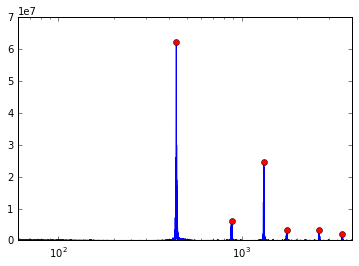

['A4']
C4+A4_PopOrgan


/Users/samdixon/miniconda/envs/seminar-env/lib/python3.5/site-packages/ipykernel/__main__.py:31: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/Users/samdixon/miniconda/envs/seminar-env/lib/python3.5/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


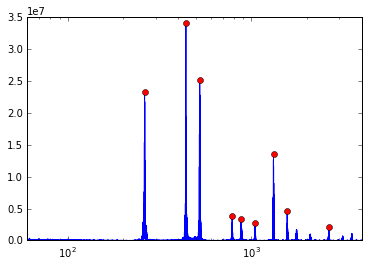

['C4', 'A4']
F3_PopOrgan


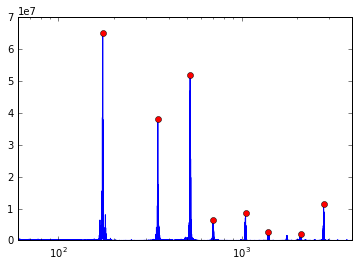

['F3']
F4_CathedralOrgan


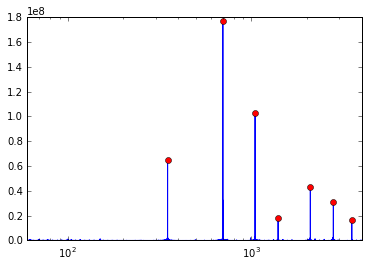

['F4', 'A7']


In [66]:
test_files = ['A4_PopOrgan.aif', 'C4+A4_PopOrgan.aif', 'F3_PopOrgan.aif', 'F4_CathedralOrgan.aif']
for path in [os.path.join('./sound_files/', f) for f in test_files]:
    print(os.path.basename(path)[:-4])
    data, frequencies = read_aiff(path)
    peak_freq, peak_height = find_peaks(data, frequencies)
    _, notes = match_notes(peak_freq)
    plt.show()
    print(notes)

/Users/samdixon/miniconda/envs/seminar-env/lib/python3.5/site-packages/ipykernel/__main__.py:31: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/Users/samdixon/miniconda/envs/seminar-env/lib/python3.5/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


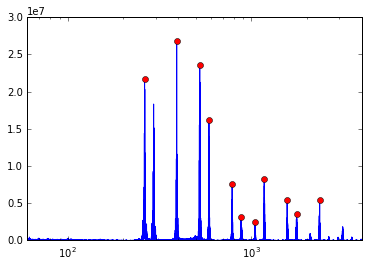

['C4', 'G4', 'D5', 'A5']


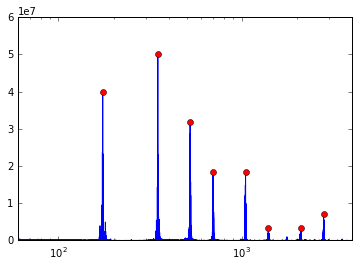

['F3']


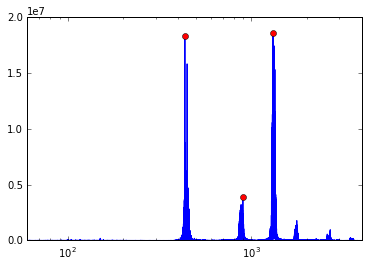

['A4', 'A5']


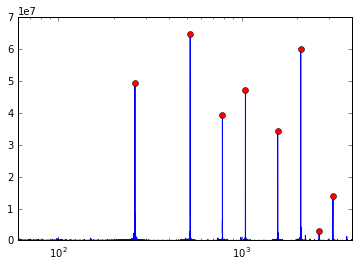

['C4', 'E7']


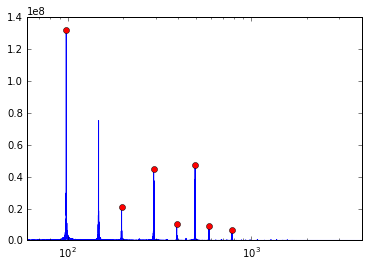

['G2']


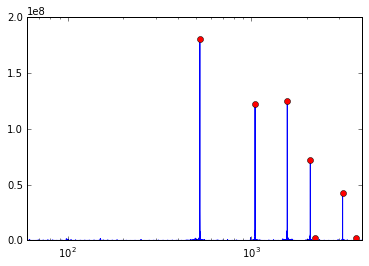

['C5', 'C#/Db7', 'A#/Bb7', 'E8']


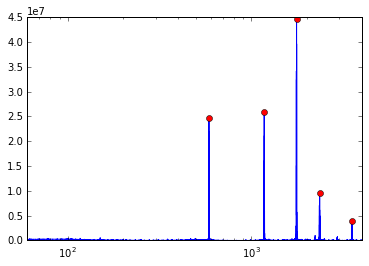

['D5']


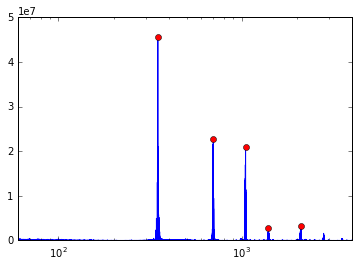

['F4']


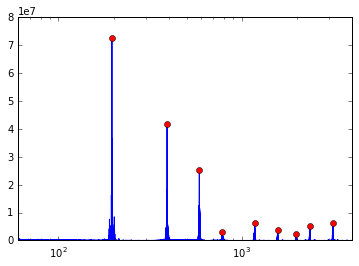

['G3', 'B6']


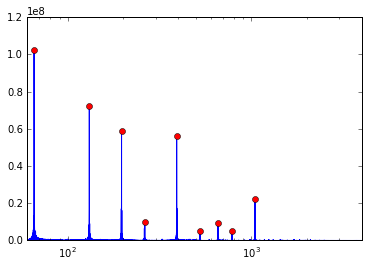

['C2', 'E5']


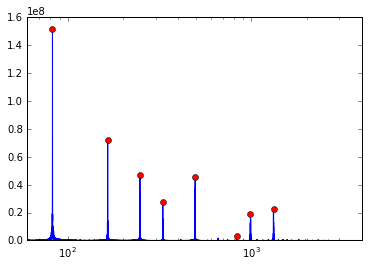

['E2', 'G#/Ab5']


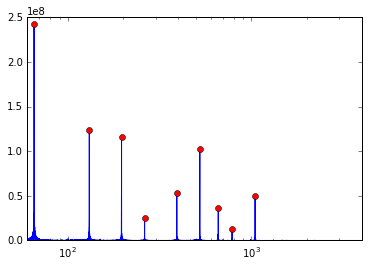

['C2', 'E5']


In [69]:
for i in range(1, 13):
    fname = os.path.join('./sound_files/', str(i)+'.aif')
    data, frequencies = read_aiff(fname)
    peak_freq, peak_height = find_peaks(data, frequencies, remove_harmonics=True)
    _, notes = match_notes(peak_freq)
    plt.show()
    print(notes)